In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset=pd.read_csv('SolarPrediction_time_aligned.csv',engine='python')
dataset=dataset.drop("Data",axis=1)
dataset=dataset.drop("Time",axis=1)
dataset=dataset.drop("TimeSunRise",axis=1)
dataset=dataset.drop("TimeSunSet",axis=1)
dataset.head(5)


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,8,2.58,51,30.43,103,77.27,11.25
1,310,2.83,51,30.43,103,153.44,9.00
2,1206,2.16,51,30.43,103,142.04,7.87
3,1505,2.21,51,30.43,103,144.12,18.00
4,1809,2.25,51,30.43,103,67.42,11.25


In [2]:
dataset=dataset.values

取出來的數字不知道為甚麼做%會一直變 ==
把值用一變數取出改為int再寫入
重複執行會重複扣==

In [3]:

# take=np.zeros(len(dataset))
# take=dataset[:,0]


In [4]:
# take[:]=take[:]-1472724000
# take

In [5]:
# for i in range(0,len(dataset)):
#     take[i]=take[i]%(60*60*24)

# print(dataset[0,0])

把take寫回去

In [6]:
# dataset[:,0]=take
# print(dataset)

之前用作存時間整理的

In [7]:
# store=pd.DataFrame(dataset,columns=["UNIXTime","Data","Time","Radiation","Temperature","Pressure","Humidity","WindDirection(Degrees)","Speed","TimeSunRise","TimeSunSet"])
# store.to_csv("SolarPrediction_time_aligned.csv",index=False)

在這邊scalar會被設定為對七筆資料做scalar
導致最後輸出結果無法scalar回去
到後面分資料實在scalar
存有對輸出scalar的資料

In [8]:
dataset[:,1]

array([2.58, 2.83, 2.16, ..., 1.21, 1.19, 1.21])

In [9]:


np.random.seed(7)


dataset=dataset.astype('float32')

scalar1=MinMaxScaler(feature_range=(0,1))
scalar2=MinMaxScaler(feature_range=(0,1))
scalar_dim=dataset[:,1]
dataset=scalar1.fit_transform(dataset)

scalar_dim=scalar_dim.reshape(len(dataset),1)
print(scalar_dim)
scalar_dim=scalar2.fit_transform(scalar_dim)
print(scalar_dim)


[[2.58]
 [2.83]
 [2.16]
 ...
 [1.21]
 [1.19]
 [1.21]]
[[9.1866386e-04]
 [1.0748992e-03]
 [6.5618852e-04]
 ...
 [6.2494189e-05]
 [4.9995375e-05]
 [6.2494189e-05]]


In [10]:
train_size=int(len(dataset)*0.67)
test_size=len(dataset)- train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]

print(train.shape)
print(train)
print(test.shape)
#print(test)

(21899, 7)
[[8.12215731e-05 9.18663864e-04 4.59459424e-01 ... 1.00000000e+00
  2.14472279e-01 2.77777791e-01]
 [3.58535210e-03 1.07489922e-03 4.59459424e-01 ... 1.00000000e+00
  4.26137954e-01 2.22222224e-01]
 [1.39817130e-02 6.56188524e-04 4.59459424e-01 ... 1.00000000e+00
  3.94458920e-01 1.94320992e-01]
 ...
 [6.71818376e-01 6.42064810e-02 4.59459424e-01 ... 9.78947401e-01
  1.99966654e-01 2.77777791e-01]
 [6.75310910e-01 7.20807388e-02 4.59459424e-01 ... 9.78947401e-01
  1.35469347e-01 1.94320992e-01]
 [6.78791821e-01 1.17988944e-01 4.59459424e-01 ... 9.78947401e-01
  7.77524635e-02 1.11111112e-01]]
(10787, 7)


以下列的函式去執行
可以將每一筆資料對應前五個時間點及七筆資料
又有幾百筆資料做對應
故會有三為資料
注 在這邊分成target及分析內容

In [11]:
def create_dataset(dataset,look_back):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        #a=dataset第0行i~i+look_back個
        a=dataset[i:(i+look_back),0:7]
        dataX.append(a)
        dataY.append(dataset[i+look_back,1])
    return np.array(dataX),np.array(dataY)

    

In [12]:
#根據前面幾個資料來看下一步 彙整成look_back行的資料
#X用以輸入 Y用用以predict
look_back=5
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)
print(testX.shape)
#print(testX)
print(testY.shape)
print(trainX.shape)
print(trainY.shape)


(10781, 5, 7)
(10781,)
(21893, 5, 7)
(21893,)


In [13]:
#轉為三維 再不是三圍的情況下
# trainX=np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
# testX=np.reshape(testX,(testX.shape[0],testX.shape[1],1))

In [14]:
model=Sequential()
#添加的一個 LSTM 層。
#這個層有一個名為 4 的參數，這表示該 LSTM 層有 4 個隱藏單元（hidden units）。
# input_shape=(look_back, 1) 則指定了輸入數據的形狀，
# 其中 look_back 是時間窗口的大小，1 表示每個時間步的特徵數。
model.add(LSTM(4,input_shape=(look_back,7)))
#Dense全連接後輸出一層
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

model.fit(trainX,trainY,epochs=5,batch_size=1,verbose=2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 192       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
21893/21893 - 59s - loss: 0.0043 - 59s/epoch - 3ms/step
Epoch 2/5
21893/21893 - 60s - loss: 0.0031 - 60s/epoch - 3ms/step
Epoch 3/5


KeyboardInterrupt: 

In [ ]:
trainPre=model.predict(trainX)
testPre=model.predict(testX)
trainPre.shape
testPre.shape

119/119 [==============================] - 1s 3ms/step


(3796, 1)

In [ ]:
trainPre=scalar2.inverse_transform(trainPre)
trainY=scalar2.inverse_transform([trainY])
testPre=scalar2.inverse_transform(testPre)
testY=scalar2.inverse_transform([testY])
print(trainPre.shape)
print(trainY.shape)
print(testPre.shape)
print(testY.shape)

(7712, 1)
(1, 7712)
(3796, 1)
(1, 3796)


In [ ]:
print(trainY.shape)
print(trainPre.shape)
print(trainY[0,1])
print(trainPre[1,0])


(1, 7712)
(7712, 1)
2.0699998509781423
0.11502531


In [ ]:
#MSE是均方根誤差 即平均誤差 會被平均除下去 所以數據多不代表誤差會增加
trainScore=math.sqrt(mean_squared_error(trainY[0,:],trainPre[:,0]))
print('Train Score:%.2f RMSE'%(trainScore))
testScore=math.sqrt(mean_squared_error(testY[0,:],testPre[:,0]))
print('Test Score:%.2f RMSE'%(testScore))

Train Score:93.14 RMSE
Test Score:96.50 RMSE


In [ ]:
print(trainY[0,:])
print(trainPre[:,0].shape)

[2.15000019 2.06999985 2.05999993 ... 1.26999994 1.26999994 1.25      ]
(7712,)


In [ ]:
trainPredictplot=np.empty_like(scalar_dim)
#print(trainPredictplot)
trainPredictplot[:,:]=np.nan
#print(trainPredictplot)
trainPredictplot[look_back:len(trainPre)+look_back,:]=trainPre
print(trainPredictplot)
print(trainPredictplot.shape)

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
(11520, 1)


In [ ]:
testPredictPlot=np.empty_like(scalar_dim)
testPredictPlot[:,:]=np.NaN
testPredictPlot[len(trainPre)+(look_back*2)+1:len(dataset)-1,:]=testPre
print(testPredictPlot)

[[      nan]
 [      nan]
 [      nan]
 ...
 [975.25543]
 [974.569  ]
 [      nan]]


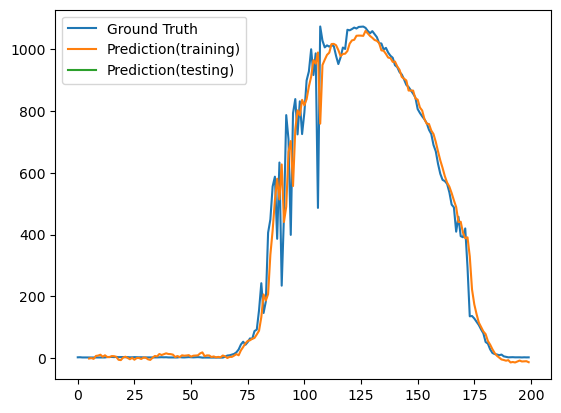

In [ ]:
ground_truth=scalar2.inverse_transform(scalar_dim)
plt.plot(ground_truth[0:200],label='Ground Truth')
plt.plot(trainPredictplot[0:200],label='Prediction(training)')
plt.plot(testPredictPlot[0:200],label='Prediction(testing)')
plt.legend()
plt.show()

In [ ]:
# import sys
# numpy.set_printoptions(threshold=sys.maxsize)
# detect=scalar.inverse_transform(dataset)
# print(detect[400:500,:])